# setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

from tab_transformer_pytorch.ft_transformer import FTTransformer

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# data

In [3]:
class tabular(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y.reshape(-1, 1))
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx, :].float()

In [4]:
ds = 'higgs_small'

X_train = np.load('data/{}/N_train.npy'.format(ds))
y_train = np.load('data/{}/y_train.npy'.format(ds))
X_val = np.load('data/{}/N_val.npy'.format(ds))
y_val = np.load('data/{}/y_val.npy'.format(ds))
X_test = np.load('data/{}/N_test.npy'.format(ds))
y_test = np.load('data/{}/y_test.npy'.format(ds))

In [5]:
# sim, esse puto me deu um ds com nan
nan, _ = np.where(np.isnan(X_train))
X_train = np.delete(X_train, nan, axis = 0)
y_train = np.delete(y_train, nan, axis = 0)

In [6]:
scaler = StandardScaler()
scaler.fit(X_train);
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [7]:
train_set = tabular(X_train, y_train)
val_set = tabular(X_val, y_val)
test_set = tabular(X_test, y_test)

# train

In [26]:
def train(model, loader, optimizer, criterion):
    model.train()
    cost = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        yhat = model.forward(np.zeros(0), x)
        # yhat = model.forward(np.zeros(0), encoder.forward(x))
        yhat = torch.sigmoid(yhat)
        loss = criterion(yhat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss.item() * x.shape[0]
    return cost / loader.dataset.__len__()

In [27]:
def eval(model, loader, criterion):
    model.eval()
    cost = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        yhat = model.forward(np.zeros(0), x)
        # yhat = model.forward(np.zeros(0), encoder.forward(x))
        yhat = torch.sigmoid(yhat)
        yhat = torch.round(yhat)
        loss = criterion(yhat, y)

        cost += loss.item() * x.shape[0]
    return cost / loader.dataset.__len__()

In [28]:
hidden = 128
p = train_set.X.shape[1]

model = FTTransformer(
    categories = (),      # tuple containing the number of unique values within each category
    num_continuous = p,                # number of continuous values
    dim = hidden,                           # dimension, paper set at 32
    dim_out = train_set.y.shape[1],                        # binary prediction, but could be anything
    depth = 6,                          # depth, paper recommended 6
    heads = 8,                          # heads, paper recommends 8
    attn_dropout = 0.1,                 # post-attention dropout
    ff_dropout = 0.1                    # feed forward dropout
).to(DEVICE)

In [29]:
btsz = 512
lr = 1e-3
l2 = 1e-4
epochs = 100

optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = l2)
criterion = nn.BCEWithLogitsLoss()

In [30]:
train_loader = DataLoader(train_set, batch_size = btsz, shuffle = True)
val_loader = DataLoader(val_set, batch_size = btsz)

log = []

100%|██████████| 100/100 [11:28<00:00,  6.89s/it]


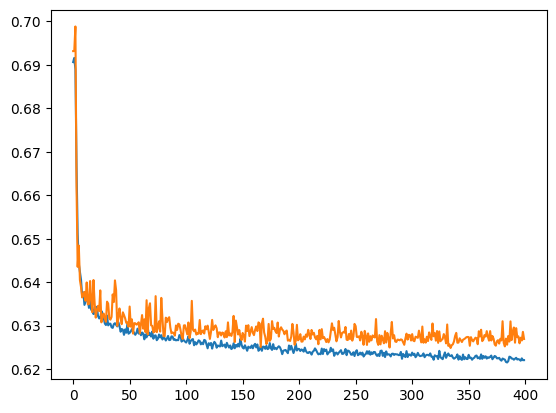

In [42]:
for epoch in tqdm(range(epochs)):
    loss_train = train(model, train_loader, optimizer, criterion)

    loss_val = eval(model, val_loader, criterion)
    # print(loss_train, loss_val)
    log.append([loss_train, loss_val])
plt.plot(log);

In [43]:
acc = nn.L1Loss()

test_loader = DataLoader(test_set, batch_size = btsz)
1 - eval(model, test_loader, acc)

0.7049974501984027